In [1]:
import pickle
import numpy as np

import uproot
import boost_histogram as bh
import mplhep
import glob
import os
import vector
import shutil
import numba
from tqdm.notebook import tqdm

mplhep.style.use("CMS")

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import uproot
import awkward as ak
import vector

vector.register_awkward()

In [2]:
import sys

sys.path += ["../../mlpf/plotting/"]
sys.path += ["../../mlpf/"]

from plot_utils import SAMPLE_LABEL_CMS, pid_to_text, EXPERIMENT_LABELS, experiment_label, EVALUATION_DATASET_NAMES

neutral_pids = [130, 310, 2112, 3122, 3322]
charged_pids = [211, 321, 2212, 3112, 3222, 3312, 3334]

W_PDGID = 24
MU_PDGID = 13

In [3]:
def sample_label(ax, sample, additional_text="", x=0.03, y=0.97, fontsize=20):
    text = EVALUATION_DATASET_NAMES[sample]
    plt.text(x, y, text + additional_text, ha="left", va="top", transform=ax.transAxes, fontsize=fontsize)

def cms_label(ax):
    return experiment_label(ax, experiment="CMS", tag1=" Simulation (Preliminary)", tag2="Run 3 (14 TeV)", x1=0.13)

In [4]:
@numba.njit
def deltaphi(phi1, phi2):
    diff = phi1 - phi2
    return np.arctan2(np.sin(diff), np.cos(diff))

@numba.njit
def deltar(eta1, phi1, eta2, phi2):
    deta = eta1 - eta2
    dphi = deltaphi(phi1, phi2)
    return np.sqrt(deta**2 + dphi**2)

@numba.njit
def match_particles(vecs1, vecs2, deltaR_cut):
    
    eta1, phi1 = vecs1.eta, vecs1.phi
    eta2, phi2 = vecs2.eta, vecs2.phi
    
    nev = len(eta1)
    ptcl_inds_1_ev = []
    ptcl_inds_2_ev = []
    best_drs_ev = []
    for iev in range(nev):
        ptcl_inds_1 = []
        ptcl_inds_2 = []
        best_drs = []

        # loop over the first collection
        pfs_used = np.zeros(len(eta2[iev]))
        for ip1 in range(len(eta1[iev])):
            # compute deltaR from this particle to all particles in the other collection
            drs = 999*np.ones(len(eta2[iev]), dtype=np.float64)

            # loop over the second collection
            for ip2 in range(len(eta2[iev])):
                if pfs_used[ip2]==1:
                    continue
                _eta1 = eta1[iev][ip1]
                _eta2 = eta2[iev][ip2]
                _phi1 = phi1[iev][ip1]
                _phi2 = phi2[iev][ip2]

                dr = deltar(_eta1, _phi1, _eta2, _phi2)
                drs[ip2] = dr

            if len(drs) > 0:
                # find closest match to this particle
                min_idx_dr = np.argmin(drs)

                # has to be closer than the deltaR_cut
                if drs[min_idx_dr] < deltaR_cut:
                    ptcl_inds_1.append(ip1)
                    ptcl_inds_2.append(min_idx_dr)
                    best_drs.append(drs[min_idx_dr])
                    pfs_used[min_idx_dr] = 1
                
        ptcl_inds_1_ev.append(ptcl_inds_1)
        ptcl_inds_2_ev.append(ptcl_inds_2)
        best_drs_ev.append(best_drs)
    return ptcl_inds_1_ev, ptcl_inds_2_ev, best_drs_ev


def compute_relative_isolation(vecs, dr=0.4):
    """
    Compute relative isolation per particle:
    RelIso = sum_pt_neighbors_within_dR / pt_particle

    Parameters:
    - vecs: awkward array with Momentum4D behavior
    - dr: deltaR threshold to consider neighbors

    Returns:
    - RelIso: awkward array of relative isolation values, same shape as vecs
    """
    # Pair each particle with all others in the same event
    pairs = ak.cartesian([vecs, vecs], axis=1, nested=True)
    cand, neighbor = ak.unzip(pairs)

    # Compute deltaR between candidate and neighbors
    delta_r = cand.deltaR(neighbor)

    # Mask out self-comparisons
    is_not_self = delta_r > 0
    is_neighbor = (delta_r < dr) & is_not_self

    # Sum neighbor pt within cone if pdgid is ch.had/n.had/photon
    msk = is_neighbor & ( (neighbor.pdgId==211) | (neighbor.pdgId==130) | (neighbor.pdgId==22) )
    neighbor_pt = ak.where(msk, neighbor.pt, 0)    
    sum_neighbor_pt = ak.sum(neighbor_pt, axis=-1)

    # Candidate pt (same shape as sum_neighbor_pt)
    cand_pt = cand.pt[:, :, 0]  # broadcasted first particle in each pair row

    # Compute isolation
    RelIso = sum_neighbor_pt / cand_pt

    return RelIso

# Explore definition of isolation

In [5]:
! ls ../../data/CMSSW_15_0_5_mlpf_v2.5.0_p04/TTbar_noPU_mlpfpu/

step4_NANO_btv_1.root step4_NANO_btv_4.root step4_NANO_btv_7.root
step4_NANO_btv_2.root step4_NANO_btv_5.root step4_NANO_btv_8.root
step4_NANO_btv_3.root step4_NANO_btv_6.root step4_NANO_btv_9.root


In [6]:
skimmed_vars = [
    "GenPart_pt",
    "GenPart_eta",
    "GenPart_phi",
    "GenPart_mass",
    "GenPart_pdgId",
    "GenPart_status",
    "GenPart_genPartIdxMother",
    "GenCands_pt",
    "GenCands_eta",
    "GenCands_phi",
    "GenCands_mass",
    "GenCands_pdgId",
    "GenCands_charge",
    "PFCands_pt",
    "PFCands_eta",
    "PFCands_phi",
    "PFCands_mass",
    "PFCands_pdgId",
    "GenPart_pdgId",    
]

In [7]:
def remap_pid(data):
    pid = np.abs(np.asarray(ak.flatten(data["GenCands_pdgId"])))
    pa = ak.flatten(np.abs(data["GenCands_pdgId"]))
    pc = ak.flatten(np.abs(data["GenCands_charge"]))
    pid[(pa!=11) & (pa!=13) & (pa!=22) & (pc==1)] = 211
    pid[(pa!=11) & (pa!=13) & (pa!=22) & (pc==0)] = 130
    data["GenCands_pid"] = ak.unflatten(pid, ak.count(data["GenCands_pdgId"], axis=1))
    data["PFCands_pid"] = np.abs(data["PFCands_pdgId"])

In [8]:
save_as = {
    "cms_pf_qcd_nopu": "QCD_noPU",
    "cms_pf_ttbar_nopu": "TTbar_noPU",
}

dataset = "cms"
sample = "cms_pf_ttbar_nopu"

In [9]:
data_pfs = []
data_mlpfs = []
for ifile in range(1,7):
    print(ifile)
    ev_pf = uproot.open(f"../../data/CMSSW_15_0_5_mlpf_v2.5.0_p04/{save_as[sample]}_pf/step4_NANO_btv_{ifile}.root").get("Events")
    ev_mlpf = uproot.open(f"../../data/CMSSW_15_0_5_mlpf_v2.5.0_p04/{save_as[sample]}_mlpfpu/step4_NANO_btv_{ifile}.root").get("Events")
    
    ### remap PF Reco PIDs and define reliso
    data_pf = ev_pf.arrays(skimmed_vars)
    remap_pid(data_pf)
    
    gen_vecs = ak.zip(
        {
            "pt": data_pf["GenCands_pt"],
            "eta": data_pf["GenCands_eta"],
            "phi": data_pf["GenCands_phi"],
            "mass": data_pf["GenCands_mass"],
            "pdgId": data_pf["GenCands_pdgId"],
        },
        with_name="Momentum4D",
    )    
    pf_vecs = ak.zip(
        {
            "pt": data_pf["PFCands_pt"],
            "eta": data_pf["PFCands_eta"], 
            "phi": data_pf["PFCands_phi"], 
            "mass": data_pf["PFCands_mass"], 
            "pdgId": data_pf["PFCands_pdgId"],
        },
        with_name="Momentum4D",
    )   
    
    data_pf["GenCands_reliso03"] = compute_relative_isolation(gen_vecs, dr=0.3)
    data_pf["PFCands_reliso03"] = compute_relative_isolation(pf_vecs, dr=0.3)

    data_pf["GenCands_reliso05"] = compute_relative_isolation(gen_vecs, dr=0.5)
    data_pf["PFCands_reliso05"] = compute_relative_isolation(pf_vecs, dr=0.5)
    
    data_pfs.append(data_pf)

    ### remap MLPF Reco PIDs and define reliso
    data_mlpf = ev_mlpf.arrays(skimmed_vars)
    remap_pid(data_mlpf)

    gen_vecs = ak.zip(
        {
            "pt": data_mlpf["GenCands_pt"],
            "eta": data_mlpf["GenCands_eta"],
            "phi": data_mlpf["GenCands_phi"],
            "mass": data_mlpf["GenCands_mass"],
            "pdgId": data_mlpf["GenCands_pdgId"],
        },
        with_name="Momentum4D",
    )        
    pf_vecs = ak.zip(
        {
            "pt": data_mlpf["PFCands_pt"], 
            "eta": data_mlpf["PFCands_eta"], 
            "phi": data_mlpf["PFCands_phi"], 
            "mass": data_mlpf["PFCands_mass"], 
            "pdgId": data_mlpf["PFCands_pdgId"],
        },
        with_name="Momentum4D",
    )    
    
    data_mlpf["GenCands_reliso03"] = compute_relative_isolation(gen_vecs, dr=0.3)
    data_mlpf["PFCands_reliso03"] = compute_relative_isolation(pf_vecs, dr=0.3)

    data_mlpf["GenCands_reliso05"] = compute_relative_isolation(gen_vecs, dr=0.5)
    data_mlpf["PFCands_reliso05"] = compute_relative_isolation(pf_vecs, dr=0.5)    
    
    data_mlpfs.append(data_mlpf)    

1


/Users/fmokhtar/miniconda3/envs/coffea-env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(
/Users/fmokhtar/miniconda3/envs/coffea-env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


2
3
4
5
6


In [10]:
data_pf = ak.concatenate(data_pfs)
data_mlpf = ak.concatenate(data_mlpfs)

# Plot RelIso

In [11]:
color_code = {
    "Gen": "tab:blue",
    "PF": "tab:orange",
    "MLPF": "tab:red",
}

linestyle = {
    'Gen': '--',
    'PF': '--',
    'MLPF': '-',
}

b_reliso = {
    -1: np.linspace(0,6,100),
    211: np.linspace(0,6,100),
    130: np.linspace(0,6,100),
    22: np.linspace(0,6,100),
    11: np.linspace(0,6,100),
    13: np.linspace(0,4,50),
}

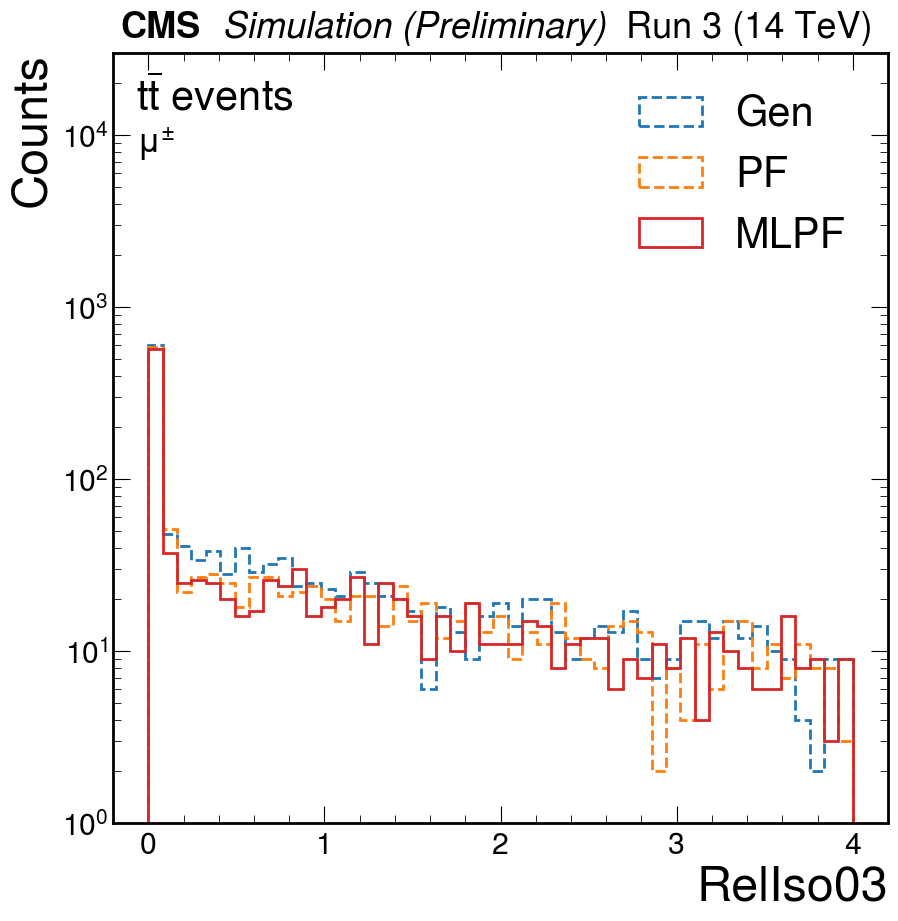

In [13]:
pid = MU_PDGID

# make plot
fig, ax = plt.subplots(figsize=(10,10))

ax.hist(ak.flatten(data_pf["GenCands_reliso03"][data_pf["GenCands_pdgId"]==pid]), bins=b_reliso[pid], histtype="step", lw=2, linestyle=linestyle["Gen"], color=color_code["Gen"], label="Gen")
ax.hist(ak.flatten(data_pf["PFCands_reliso03"][data_pf["PFCands_pdgId"]==pid]), bins=b_reliso[pid], histtype="step", lw=2, linestyle=linestyle["PF"], color=color_code["PF"], label="PF")
ax.hist(ak.flatten(data_mlpf["PFCands_reliso03"][data_mlpf["PFCands_pdgId"]==pid]), bins=b_reliso[pid], histtype="step", lw=2, linestyle=linestyle["MLPF"], color=color_code["MLPF"], label="MLPF")

# ax.axvline(0.15, c="grey", linestyle="--", label="RelIso03=0.15")

ax.set_xlabel("RelIso03", fontsize=35)
ax.set_ylabel("Counts", fontsize=35)
ax.set_yscale("log")
ax.legend(fontsize=30)

ax.set_ylim(1,3*10**4)

cms_label(ax)
sample_label(ax, sample, additional_text=" events", fontsize=30)
plt.text(0.03, 0.87, pid_to_text[pid], transform=ax.transAxes, fontsize=25)
    
plt.savefig(f"/Users/fmokhtar/Desktop/mlpf/{save_as[sample]}/lepisolation/1dhist_{pid}_cone03.pdf")

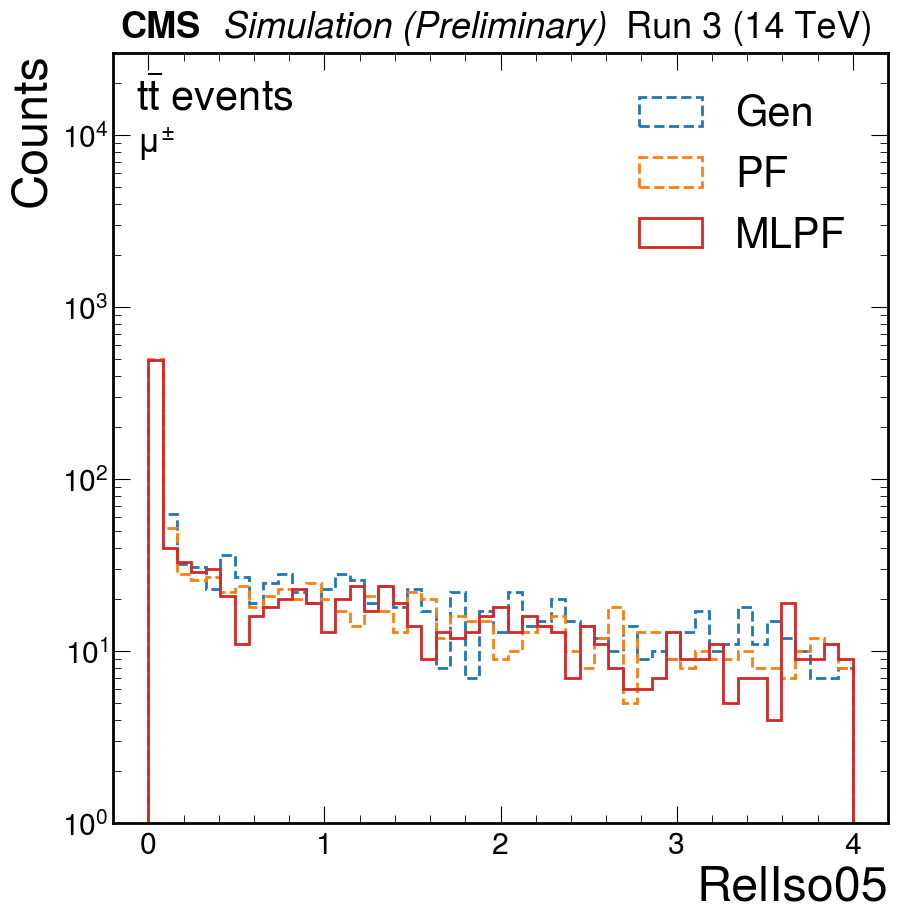

In [14]:
pid = MU_PDGID

# make plot
fig, ax = plt.subplots(figsize=(10,10))

ax.hist(ak.flatten(data_pf["GenCands_reliso05"][data_pf["GenCands_pdgId"]==pid]), bins=b_reliso[pid], histtype="step", lw=2, linestyle=linestyle["Gen"], color=color_code["Gen"], label="Gen")
ax.hist(ak.flatten(data_pf["PFCands_reliso05"][data_pf["PFCands_pdgId"]==pid]), bins=b_reliso[pid], histtype="step", lw=2, linestyle=linestyle["PF"], color=color_code["PF"], label="PF")
ax.hist(ak.flatten(data_mlpf["PFCands_reliso05"][data_mlpf["PFCands_pdgId"]==pid]), bins=b_reliso[pid], histtype="step", lw=2, linestyle=linestyle["MLPF"], color=color_code["MLPF"], label="MLPF")

# ax.axvline(0.15, c="grey", linestyle="--", label="RelIso03=0.15")

ax.set_xlabel("RelIso05", fontsize=35)
ax.set_ylabel("Counts", fontsize=35)
ax.set_yscale("log")
ax.legend(fontsize=30)

ax.set_ylim(1,3*10**4)

cms_label(ax)
sample_label(ax, sample, additional_text=" events", fontsize=30)
plt.text(0.03, 0.87, pid_to_text[pid], transform=ax.transAxes, fontsize=25)

plt.savefig(f"/Users/fmokhtar/Desktop/mlpf/{save_as[sample]}/lepisolation/1dhist_{pid}_cone05.pdf")

# Make study

In [15]:
pt_cut = 5    # pt cut on muons (PF paper was 15GeV)

# there are ~3k Gen muons with pt>5
ak.sum( (abs(data_pf["GenCands_pdgId"])==MU_PDGID) & (data_pf["GenCands_pt"]>pt_cut) )

2925

In [16]:
########## match GenPart muons to GenCand muons

dR_cut = 0.15    # dR matching crtierion

# (1) define the GenCand and GenPart collections
gen_cands = ak.zip(
    { 
        "pt": data_pf["GenCands_pt"], 
        "eta": data_pf["GenCands_eta"], 
        "phi": data_pf["GenCands_phi"], 
        "mass": data_pf["GenCands_mass"],
        "pdgId": data_pf["GenCands_pdgId"],
        "GenCands_reliso03": data_pf["GenCands_reliso03"],
        "GenCands_reliso05": data_pf["GenCands_reliso05"],
    },
    with_name="Momentum4D",
)
gen_part = ak.zip(
    {
        "pt": data_pf["GenPart_pt"],
        "eta": data_pf["GenPart_eta"],
        "phi": data_pf["GenPart_phi"],
        "mass": data_pf["GenPart_mass"],
        "pdgId": data_pf["GenPart_pdgId"],
        "GenPart_status": data_pf["GenPart_status"],
        "fromW": (abs(data_pf["GenPart_pdgId"][data_pf["GenPart_genPartIdxMother"]]) == W_PDGID),         
    },
    with_name="Momentum4D",
)

# (2) select muons with pt>15GeV from both collections
msk_gen_cands = (abs(gen_cands.pdgId)==MU_PDGID) & (gen_cands.pt>pt_cut)
gen_cands = gen_cands[msk_gen_cands]

msk_gen_part = (abs(gen_part.pdgId)==MU_PDGID) & (gen_part.pt>pt_cut)
gen_part = gen_part[msk_gen_part]

# (3) run matching function
idx1, idx2, _ = match_particles(
    gen_cands,
    gen_part,
    deltaR_cut=dR_cut,
)

gen_cands = gen_cands[idx1]
gen_part = gen_part[idx2]

########## (4) after matching, define relevant GenPart information on top of GenCands
gen_cands["fromW"] = gen_part.fromW
gen_cands["GenPart_status"] = gen_part.GenPart_status

/Users/fmokhtar/miniconda3/envs/coffea-env/lib/python3.9/site-packages/numba/cpython/hashing.py:482: UserWarning: FNV hashing is not implemented in Numba. See PEP 456 https://www.python.org/dev/peps/pep-0456/ for rationale over not using FNV. Numba will continue to work, but hashes for built in types will be computed using siphash24. This will permit e.g. dictionaries to continue to behave as expected, however anything relying on the value of the hash opposed to hash as a derived property is likely to not work as expected.
  warnings.warn(msg)


In [17]:
isprompt_mu = gen_cands.fromW #& (gen_cands.GenPart_status==1)
prompt_mu_vecs = ak.zip(
    {
        "pt": gen_cands["pt"][isprompt_mu],
        "eta": gen_cands["eta"][isprompt_mu],
        "phi": gen_cands["phi"][isprompt_mu],
        "mass": gen_cands["mass"][isprompt_mu],
},
    with_name="Momentum4D",
)

isnonprompt_mu = (~gen_cands.fromW) #& (gen_cands.GenPart_status==1)
nonprompt_mu_vecs = ak.zip(
    {
        "pt": gen_cands["pt"][isnonprompt_mu],
        "eta": gen_cands["eta"][isnonprompt_mu],
        "phi": gen_cands["phi"][isnonprompt_mu],
        "mass": gen_cands["mass"][isnonprompt_mu],
},
    with_name="Momentum4D",
)

print(f"number of prompt muons: {ak.sum(prompt_mu_vecs.pt>0)}")
print(f"number of secondary muons: {ak.sum(nonprompt_mu_vecs.pt>0)}")

number of prompt muons: 1088
number of secondary muons: 1837


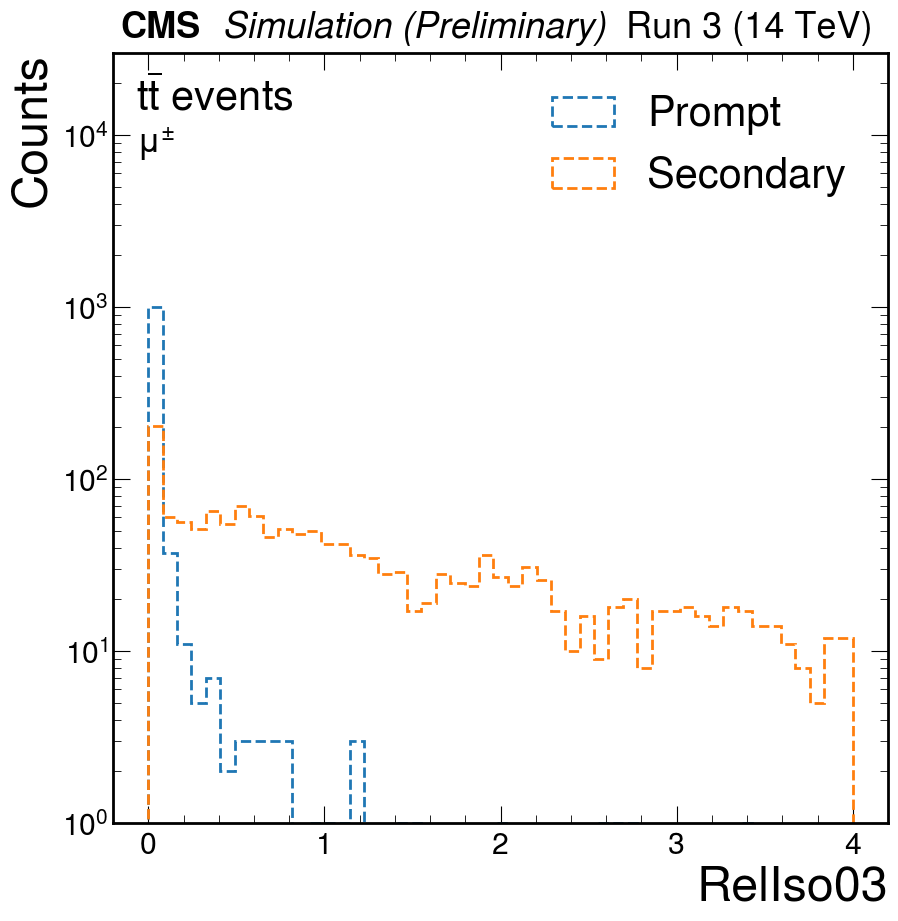

In [18]:
# make plot
fig, ax = plt.subplots(figsize=(10,10))

ax.hist(ak.flatten(gen_cands["GenCands_reliso03"][isprompt_mu]), bins=b_reliso[pid], histtype="step", lw=2, linestyle=linestyle["Gen"], color=color_code["Gen"], label="Prompt")
ax.hist(ak.flatten(gen_cands["GenCands_reliso03"][isnonprompt_mu]), bins=b_reliso[pid], histtype="step", lw=2, linestyle=linestyle["Gen"], color=color_code["PF"], label="Secondary")

# ax.axvline(0.15, c="grey", linestyle="--", label="RelIso03=0.15")

ax.set_xlabel("RelIso03", fontsize=35)
ax.set_ylabel("Counts", fontsize=35)
ax.set_yscale("log")
ax.legend(fontsize=30)

ax.set_ylim(1,3*10**4)

cms_label(ax)
sample_label(ax, sample, additional_text=" events", fontsize=30)
plt.text(0.03, 0.87, pid_to_text[pid], transform=ax.transAxes, fontsize=25)

plt.savefig(f"/Users/fmokhtar/Desktop/mlpf/{save_as[sample]}/lepisolation/1dhist_{pid}_cone03.pdf")

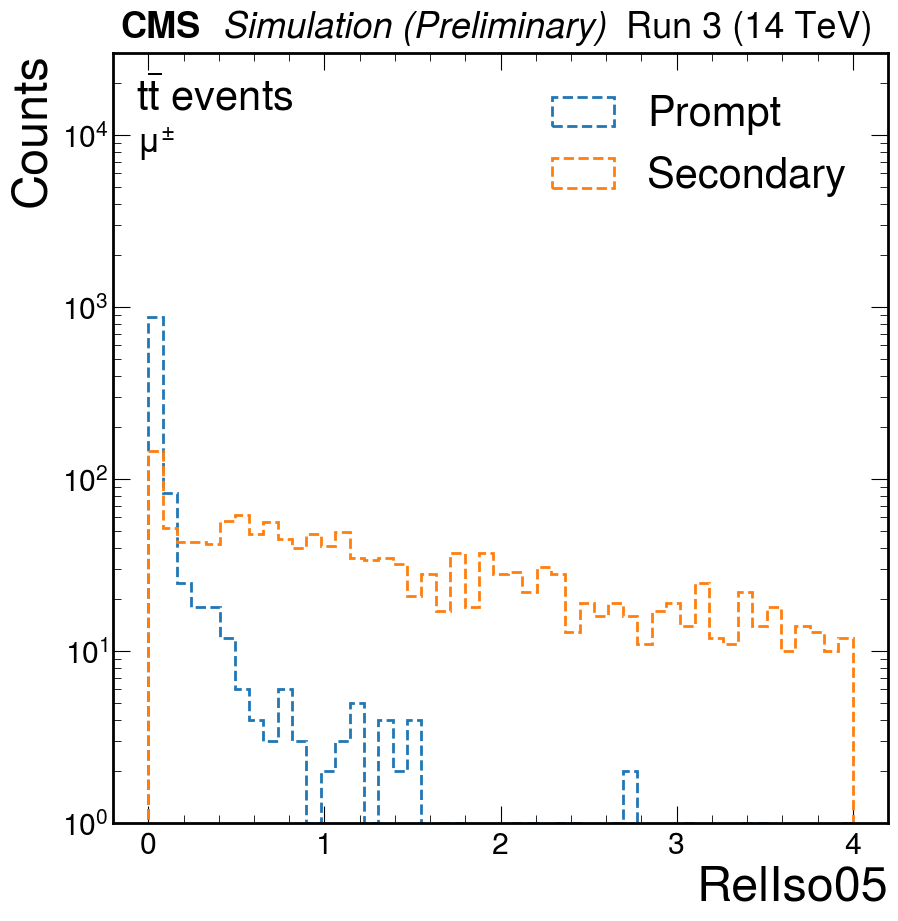

In [19]:
# make plot
fig, ax = plt.subplots(figsize=(10,10))

ax.hist(ak.flatten(gen_cands["GenCands_reliso05"][isprompt_mu]), bins=b_reliso[pid], histtype="step", lw=2, linestyle=linestyle["Gen"], color=color_code["Gen"], label="Prompt")
ax.hist(ak.flatten(gen_cands["GenCands_reliso05"][isnonprompt_mu]), bins=b_reliso[pid], histtype="step", lw=2, linestyle=linestyle["Gen"], color=color_code["PF"], label="Secondary")

# ax.axvline(0.15, c="grey", linestyle="--", label="RelIso03=0.15")

ax.set_xlabel("RelIso05", fontsize=35)
ax.set_ylabel("Counts", fontsize=35)
ax.set_yscale("log")
ax.legend(fontsize=30)

ax.set_ylim(1,3*10**4)

cms_label(ax)
sample_label(ax, sample, additional_text=" events", fontsize=30)
plt.text(0.03, 0.87, pid_to_text[pid], transform=ax.transAxes, fontsize=25)

plt.savefig(f"/Users/fmokhtar/Desktop/mlpf/{save_as[sample]}/lepisolation/1dhist_{pid}_cone05.pdf")

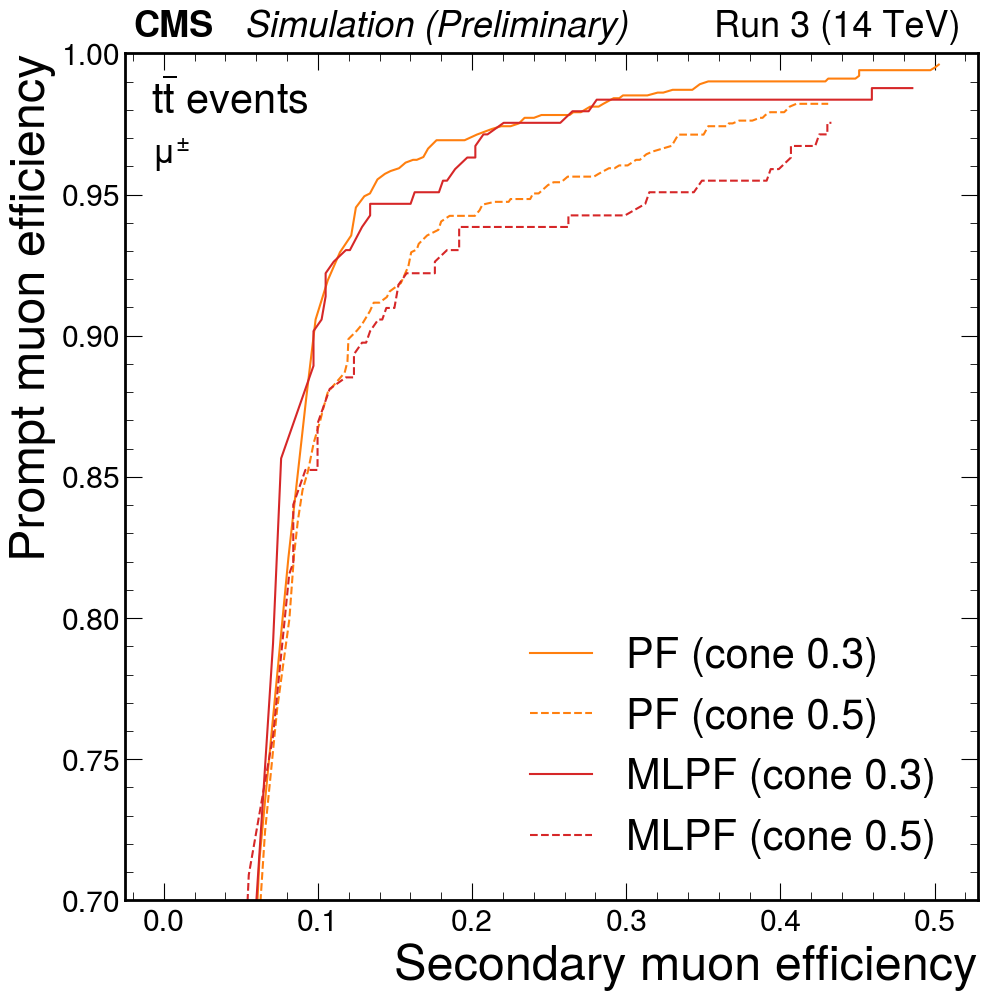

In [20]:
# https://pythia.org/manuals/pythia8305/Welcome.html
#status=22 refers to intermediate (intended to have preserved mass)

isocuts = np.linspace(0,1.5,100)

fig, ax = plt.subplots(figsize=(11, 11))

reco_mu_vecs = {}
for lab, data in {
    "PF": data_pf, 
    "MLPF": data_mlpf,
}.items():

    ###### reco-level muons    
    isreco_mu = ( 
        (abs(data["PFCands_pdgId"]) == MU_PDGID) & 
        (abs(data["PFCands_pt"]) > pt_cut) 
    )
    reco_mu_vecs[lab] = ak.zip(
        {
            "pt": data["PFCands_pt"][isreco_mu],
            "eta": data["PFCands_eta"][isreco_mu],
            "phi": data["PFCands_phi"][isreco_mu],
            "mass": data["PFCands_mass"][isreco_mu],
            "reliso03": data["PFCands_reliso03"][isreco_mu],
            "reliso05": data["PFCands_reliso05"][isreco_mu],        
    },
        with_name="Momentum4D",
    )

    # must match each prompt/nonprompt mu to some reco mu and see how the iso affects the efficiency of this matching
    idx1, idx2, _ = match_particles(
        reco_mu_vecs[lab],
        prompt_mu_vecs,
        deltaR_cut=dR_cut,
    )
    reco_mu_matched_to_prompt = ak.flatten(reco_mu_vecs[lab][idx1])

    idx1, idx2, _ = match_particles(
        reco_mu_vecs[lab], 
        nonprompt_mu_vecs,
        deltaR_cut=dR_cut,
    )
    reco_mu_matched_to_nonprompt = ak.flatten(reco_mu_vecs[lab][idx1])

    ##### plot efficiency of cones 0.3
    X = [ ( ak.sum(reco_mu_matched_to_nonprompt["reliso03"]<x)/len(reco_mu_matched_to_nonprompt) ) for x in isocuts ]
    Y = [ ( ak.sum(reco_mu_matched_to_prompt["reliso03"]<x)/len(reco_mu_matched_to_prompt) ) for x in isocuts ]    

    ax.plot(X, Y, label=f"{lab} (cone 0.3)", c=color_code[lab])

    ##### plot efficiency of cones 0.5
    X = [ ( ak.sum(reco_mu_matched_to_nonprompt["reliso05"]<x)/len(reco_mu_matched_to_nonprompt) ) for x in isocuts ]
    Y = [ ( ak.sum(reco_mu_matched_to_prompt["reliso05"]<x)/len(reco_mu_matched_to_prompt) ) for x in isocuts ]    

    ax.plot(X, Y, label=f"{lab} (cone 0.5)", linestyle="--", c=color_code[lab])

ax.set_xlabel(r"Secondary muon efficiency", fontsize=35)
ax.set_ylabel(r"Prompt muon efficiency", fontsize=35)

ax.set_ylim(0.7,1)

ax.legend(loc="lower right", fontsize=30)

cms_label(ax)
sample_label(ax, sample, additional_text=" events", fontsize=30)
plt.text(0.03, 0.87, pid_to_text[pid], transform=ax.transAxes, fontsize=25)

plt.savefig(f"/Users/fmokhtar/Desktop/mlpf/{save_as[sample]}/lepisolation/eff_mu_prompt.pdf")